<h1>Aprendizaje Supervisado</h1>
<h2>Convocatoria 1 - Proyecto 1</h2>
<h3>Estudiante: Luis Angel Motta Valero</h3>

#### 0) Cargar una de las imágenes histológicas

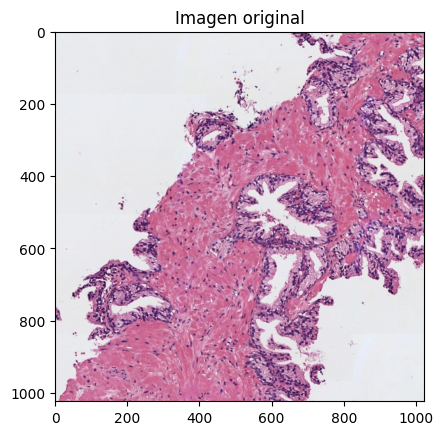

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import io
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
img = io.imread('histo_1.jpg',0)
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
rgb_p = img.astype('uint8')/255
# Visualizar la imagen
plt.imshow(rgb_p, cmap='gray')
plt.title('Imagen original')
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

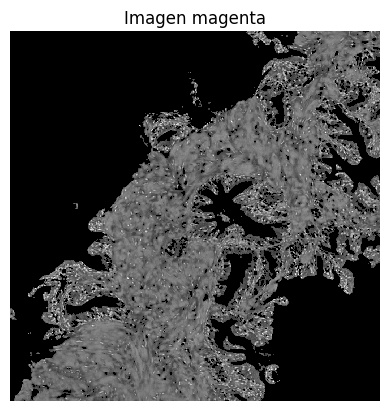

In [2]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
def convert_to_CMYK(rgb_p):
    with np.errstate(invalid='ignore',divide='ignore'):
        K = 1 - np.max(rgb_p, axis=2)
        C = (1-rgb_p[:,:,0] - K)/(1 - K)
        M = (1-rgb_p[:,:,1] - K)/(1 - K)
        Y = (1-rgb_p[:,:,2] - K)/(1 - K)

    CMYK = (np.dstack((C,M,Y,K)) * 255).astype('uint8')
    return CMYK

imagen_cmyk = convert_to_CMYK(rgb_p)
C,M,Y,K = cv2.split(imagen_cmyk)
M = M.astype('uint8')
t = M.mean()
mask = M.astype('uint8').copy()
mask[mask<t] = 0

# Visualizar la imagen del canal magenta
plt.imshow(mask, cmap='gray', interpolation='none')
plt.title('Imagen magenta')
plt.axis('off')
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

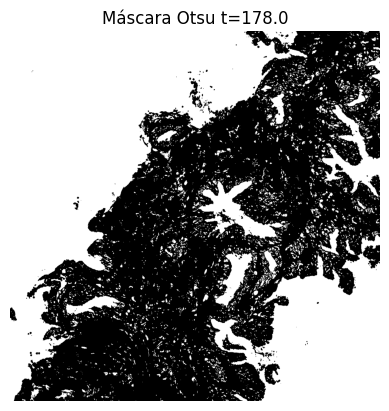

In [3]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gaus = cv2.GaussianBlur(mask, (5,5), 0)
t, mask = cv2.threshold(gray_img, 0, 1, cv2.THRESH_OTSU)

# Visualizar la máscara resultante
plt.imshow(img_gaus.astype('uint8'), cmap='gray')
plt.imshow(mask, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.axis('off')
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

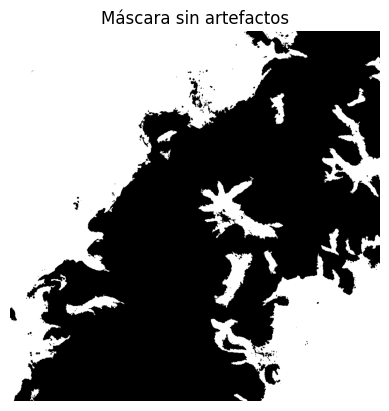

In [4]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles

from skimage import morphology, measure
mask, num = measure.label(mask, return_num=True)
clean_mask = morphology.remove_small_objects(mask, min_size=300, connectivity=2)
clean_mask = clean_mask > 0

# Visualizaer la máscara resultante
plt.imshow(clean_mask, cmap='gray')
plt.title('Máscara sin artefactos')
plt.axis('off')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

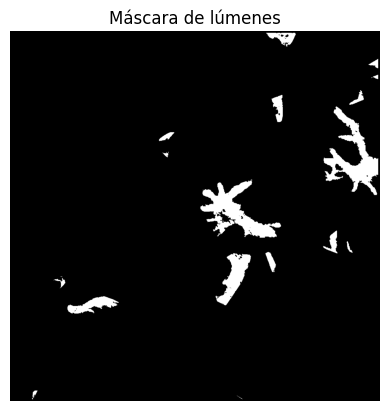

In [5]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra.

from skimage.measure import regionprops
from skimage.morphology import convex_hull_image

mask = clean_mask.astype('uint8').copy()
h, w = clean_mask.shape
ref = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(mask, ref, (0,0), 0)
cv2.floodFill(mask, ref, (1020,1020), 0)

imagen = mask.astype('uint8').copy()
new_lab, num = measure.label(mask, return_num=True)
for i in range(1, num+1): 
    objeto = new_lab == i
    objeto = objeto.astype('uint8')

    convex_image = convex_hull_image(objeto)
    convex_image = convex_image.astype('uint8')
    conts,_ = cv2.findContours(convex_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    imagen = cv2.drawContours(imagen, conts, -1, (0,255,255), 8)

# Visualizar la máscara resultante. 
plt.imshow(imagen, cmap='gray')
plt.title('Máscara de lúmenes')
plt.axis('off')
plt.show()

#### 5) Rellenar los objetos de los lúmenes

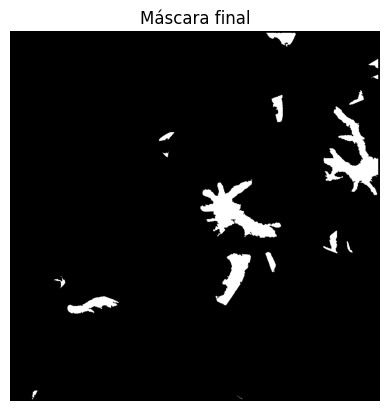

In [6]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology

from scipy.ndimage import binary_fill_holes as bfh
filled_bordes = bfh(imagen)

# Visualizar la máscara resultante
plt.imshow(filled_bordes.astype('uint8'), cmap='gray')
plt.title('Máscara final')
plt.axis('off')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

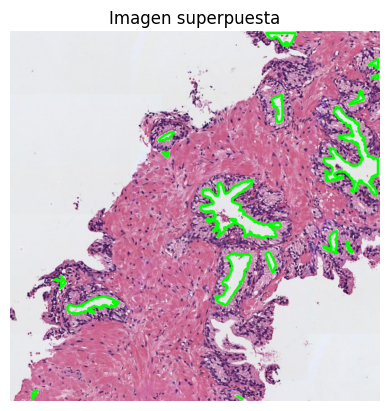

In [7]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
superpuesta = filled_bordes.astype('uint8').copy()
fondo = img.copy()
new_lab, num = measure.label(superpuesta, return_num=True)

contornos, _ = cv2.findContours(superpuesta, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(fondo, contornos, -1, (0,255,0), 5)
areas = []
for i in range(1,len(contornos)):
    objeto = new_lab == i
    prop = regionprops(objeto.astype(np.uint8))
    areas.append((np.round(prop[0].area, 4)))

# Visualizar la imagen superpuesta
plt.imshow(fondo)
plt.title('Imagen superpuesta')
plt.axis('off')
plt.show()

#### 7) Identificar y cropear el lumen más grande

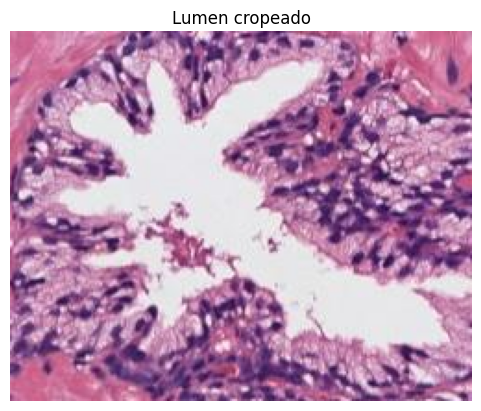

In [8]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
mayor_lumen = max(areas)
objeto_n = areas.index(mayor_lumen) + 1

# Visualizar el lumen cropeado.
new_img = img[400:600, 500:750, :]
plt.imshow(new_img, cmap='gray')
plt.title('Lumen cropeado')
plt.axis('off')
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [9]:
import math
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
objeto = new_lab == objeto_n
prop = regionprops(objeto.astype(np.uint8))
# 1) Área
print('Área:                    >>', np.round(prop[0].area, 4))
# 2) Área de la bounding box
print('Área de la bounding box: >>', np.round(prop[0].bbox_area, 4))
# 3) Área convexa
print('Área convexa:            >>',np.round(prop[0].convex_area, 4))
# 4) Exentricidad
print('Excentricidad:           >>', np.round(prop[0].eccentricity, 4))
# 5) Diámetro equivalente
print('Diámetro equivalente:    >>', np.round(prop[0].equivalent_diameter, 4))
# 6) Extensión
print('Extensión:               >>', np.round(prop[0].extent, 4))
# 7) Diámetro Feret
print('Diámetro Feret:          >>', np.round(prop[0].area/prop[0].bbox_area, 4))
# 8) Longitud del eje mayor
print('Longitud del eje mayor:  >>', np.round(prop[0].major_axis_length, 4))
# 9) Longitud del eje menor
print('Longitud del eje menor:  >>',np.round(prop[0].minor_axis_length, 4))
# 10) Orientación
print('Orientación:             >>', np.round(prop[0].orientation, 4))
# 11) Perímetro
print('Perímetro:               >>', np.round(prop[0].perimeter, 4))
# 12) Solidez
print('Solidez:                 >>', np.round(prop[0].solidity, 4))
# 13) Compacidad
print('Compacidad:              >>', np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))


Área:                    >> 13316.0
Área de la bounding box: >> 36126.0
Área convexa:            >> 27064.0
Excentricidad:           >> 0.8395
Diámetro equivalente:    >> 130.2093
Extensión:               >> 0.3686
Diámetro Feret:          >> 0.3686
Longitud del eje mayor:  >> 229.2762
Longitud del eje menor:  >> 124.5908
Orientación:             >> 0.9882
Perímetro:               >> 1290.0824
Solidez:                 >> 0.492
Compacidad:              >> 0.1005
